In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import plotly.graph_objects as go
import plotly.express as px


In [2]:
processed_df = pd.read_pickle("data/processed_recipes.pkl")
processed_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,...,processed_name,processed_instructions,processed_description,allergen_type,processed_ingredients,combined_name_ingredients,combined_texts,prep_time_str,allergen_type_str,combined_all
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",...,doddapatre tambuli karpooravalli thayir pachadi,begin make doddapatre tambuli first thoroughly...,doddapatre tambuli popular healing nourish col...,[Dairy],indian borage doddapatre curd dahi yogurt cumi...,doddapatre tambuli karpooravalli thayir pachad...,doddapatre tambuli karpooravalli thayir pachad...,30.0,Dairy,doddapatre tambuli karpooravalli thayir pachad...
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",...,fish tandoori,begin make fish tandoori keep head tail remove...,ever try fish tandoori trust equally delicious...,[Fish and Shellfish],fish curd dahi yogurt onion green chilli tando...,fish tandoori fish curd dahi yogurt onion gree...,fish tandoori fish curd dahi yogurt onion gree...,80.0,Fish and Shellfish,fish tandoori fish curd dahi yogurt onion gree...
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",...,arbi shimla mirch sabzi colocasia capsicum sabzi,begin make arbi shimla mirch sabzi first cook ...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]",colocasia root arbi green bell pepper capsicum...,arbi shimla mirch sabzi colocasia capsicum sab...,arbi shimla mirch sabzi colocasia capsicum sab...,55.0,"Tree Nuts and Peanuts, Legumes and Seeds",arbi shimla mirch sabzi colocasia capsicum sab...
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...",...,ambur style brinjal curry,begin make ambur style brinjal curry add oil h...,brinjal curry prepare different way different ...,"[Tree Nuts and Peanuts, Legumes and Seeds]",brinjal baingan eggplant onion ginger garlic p...,ambur style brinjal curry brinjal baingan eggp...,ambur style brinjal curry brinjal baingan eggp...,20.0,"Tree Nuts and Peanuts, Legumes and Seeds",ambur style brinjal curry brinjal baingan eggp...
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango raw, jaggery, turmeric powder haldi, ta...",...,mavinakayi menasinakai curry raw mango coconut...,begin make mangalorean mavinakayi menasinakai ...,mangalorean mavinakayi menasinakai curry mango...,[Legumes and Seeds],mango raw jaggery turmeric powder haldi tamari...,mavinakayi menasinakai curry raw mango coconut...,mavinakayi menasinakai curry raw mango coconut...,35.0,Legumes and Seeds,mavinakayi menasinakai curry raw mango coconut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,Spinach Oats Vada Recipe,"Spinach Leaves (Palak), Chana dal (Bengal Gram...",Spinach Oats Vada Recipe is a healthy 

In [3]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   name                       9496 non-null   object
 1   ingredients                9496 non-null   object
 2   description                9496 non-null   object
 3   instructions               9496 non-null   object
 4   cuisine                    9496 non-null   object
 5   course                     9496 non-null   object
 6   diet                       9496 non-null   object
 7   prep_time                  9496 non-null   object
 8   categorized_prep_time      9496 non-null   object
 9   cleaned_ingredients        9496 non-null   object
 10  allergens                  9496 non-null   object
 11  processed_name             9496 non-null   object
 12  processed_instructions     9496 non-null   object
 13  processed_description      9496 non-null   object
 14  allergen

Train NMF model on TF-IDF and Count Vectorizers and find the best number of topics using coherence scores 

In [4]:
def compute_coherence_scores_nmf(texts, vectorizer, num_topics_range):
    coherence_scores = []
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in texts for Gensim's coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        nmf_model = NMF(n_components=num_topics, random_state=42)
        topic_matrix = nmf_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()


    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")
    
    return coherence_scores, best_num_topics

Compare the performance of NMF model on TF-IDF vectorizer using "processed_name", "combined_name_ingredients", "combined_texts" and "combined_all" columns seperately

Number of Topics: 1, Coherence Score: 0.2793530666266214
Number of Topics: 2, Coherence Score: 0.38495706575261085
Number of Topics: 3, Coherence Score: 0.4519855774812787
Number of Topics: 4, Coherence Score: 0.41567887980239443
Number of Topics: 5, Coherence Score: 0.4017094068984167
Number of Topics: 6, Coherence Score: 0.41641310276983634


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 7, Coherence Score: 0.39820988860780027
Number of Topics: 8, Coherence Score: 0.40388609138463916
Number of Topics: 9, Coherence Score: 0.4422079641819487


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 10, Coherence Score: 0.43519887364456444


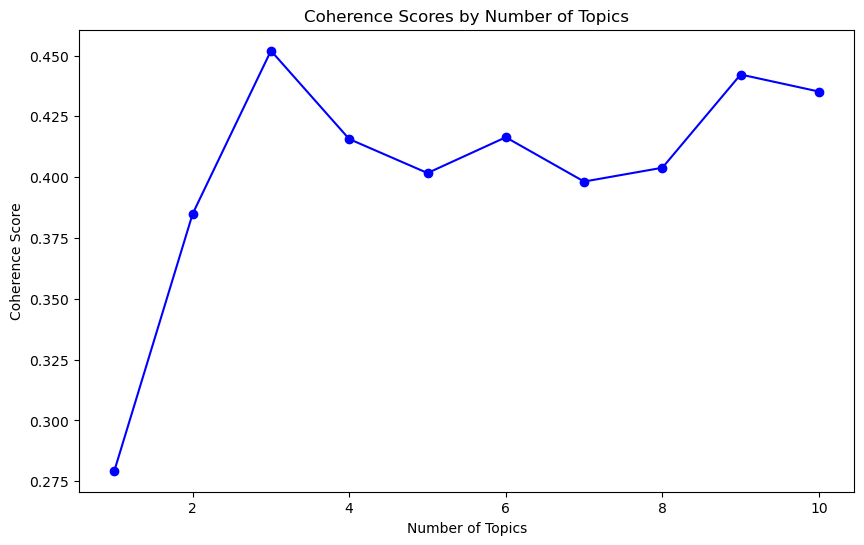

Best Number of Topics: 3 with Coherence Score: 0.4519855774812787


In [5]:
name_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['processed_name'], TfidfVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.6903408133729645
Number of Topics: 2, Coherence Score: 0.8120367885363
Number of Topics: 3, Coherence Score: 0.805994849152453
Number of Topics: 4, Coherence Score: 0.7854240722556096
Number of Topics: 5, Coherence Score: 0.8208581819469621
Number of Topics: 6, Coherence Score: 0.8218359923321409
Number of Topics: 7, Coherence Score: 0.808659868242259
Number of Topics: 8, Coherence Score: 0.7786882700000501
Number of Topics: 9, Coherence Score: 0.8012446710123048
Number of Topics: 10, Coherence Score: 0.7841664758529335


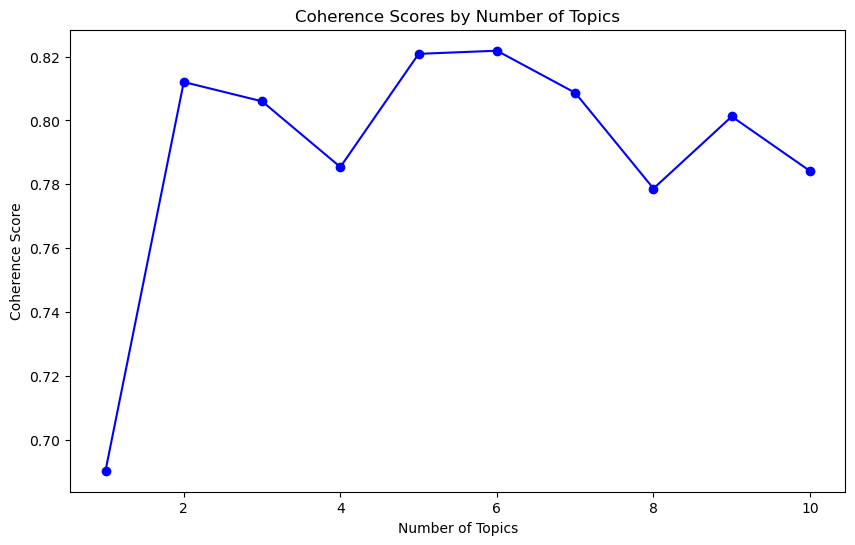

Best Number of Topics: 6 with Coherence Score: 0.8218359923321409


In [6]:
name_ingredients_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_name_ingredients'], TfidfVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.5407311233043249
Number of Topics: 2, Coherence Score: 0.5711531102886931
Number of Topics: 3, Coherence Score: 0.557462165977742
Number of Topics: 4, Coherence Score: 0.5584161510969914
Number of Topics: 5, Coherence Score: 0.600154902679054
Number of Topics: 6, Coherence Score: 0.6202997392354438
Number of Topics: 7, Coherence Score: 0.6419744791231347
Number of Topics: 8, Coherence Score: 0.6535292406211758
Number of Topics: 9, Coherence Score: 0.6395502135766706
Number of Topics: 10, Coherence Score: 0.6561146928962927
Number of Topics: 11, Coherence Score: 0.6615687068203041
Number of Topics: 12, Coherence Score: 0.653577619115299
Number of Topics: 13, Coherence Score: 0.6556498526844217
Number of Topics: 14, Coherence Score: 0.6535175654547641


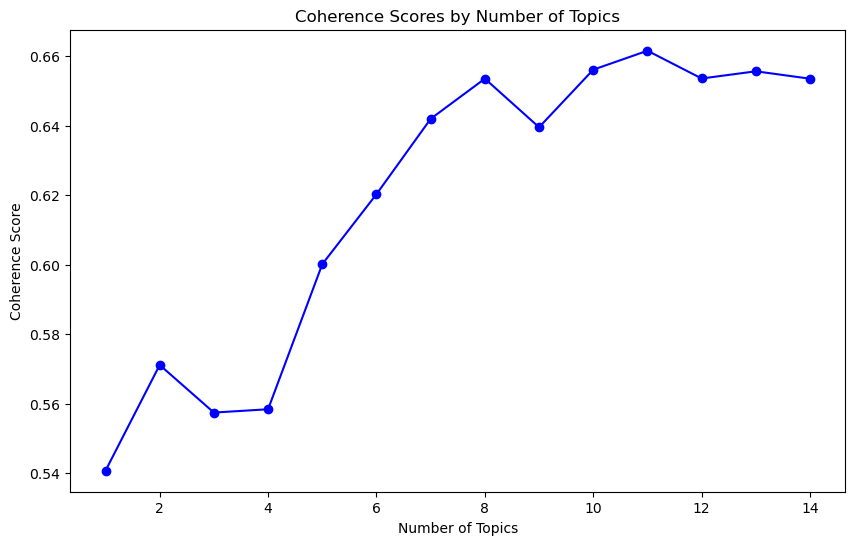

Best Number of Topics: 11 with Coherence Score: 0.6615687068203041


In [7]:
texts_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_texts'], TfidfVectorizer(), range(1, 15,1))

Number of Topics: 1, Coherence Score: 0.5428670502062035
Number of Topics: 2, Coherence Score: 0.5670927007177715
Number of Topics: 3, Coherence Score: 0.5546552252763309
Number of Topics: 4, Coherence Score: 0.542383431817473
Number of Topics: 5, Coherence Score: 0.5991019094525332
Number of Topics: 6, Coherence Score: 0.6176076722264033
Number of Topics: 7, Coherence Score: 0.659475027101382
Number of Topics: 8, Coherence Score: 0.665169110272489
Number of Topics: 9, Coherence Score: 0.6501584056522557
Number of Topics: 10, Coherence Score: 0.6677578573825753


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 11, Coherence Score: 0.6677986642575094
Number of Topics: 12, Coherence Score: 0.6494896136155093
Number of Topics: 13, Coherence Score: 0.6498716877805923
Number of Topics: 14, Coherence Score: 0.6452338329125844
Number of Topics: 15, Coherence Score: 0.6464511173500315
Number of Topics: 16, Coherence Score: 0.6525378659738519
Number of Topics: 17, Coherence Score: 0.6249305684561942


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 18, Coherence Score: 0.6268199175820519
Number of Topics: 19, Coherence Score: 0.6306870249305262


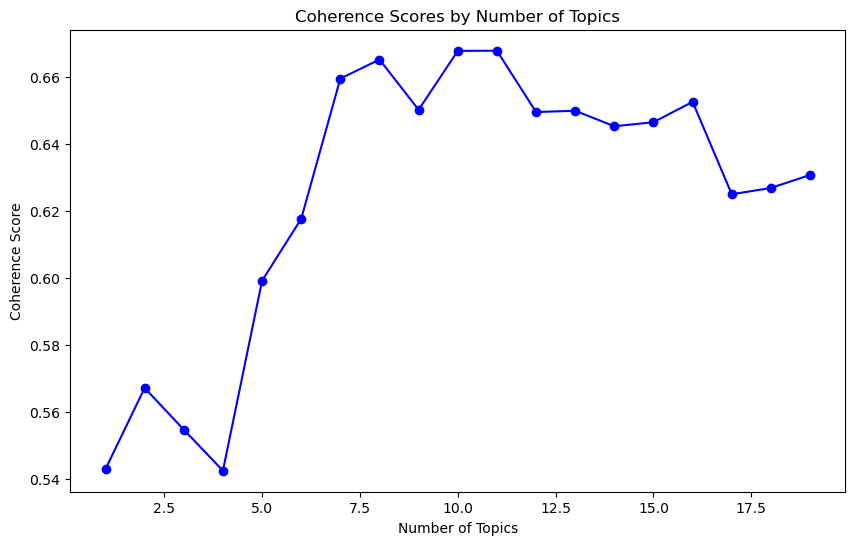

Best Number of Topics: 11 with Coherence Score: 0.6677986642575094


In [8]:
all_coherence_scores_nmf_tfidf = compute_coherence_scores_nmf(processed_df['combined_all'], TfidfVectorizer(), range(1, 20,1))

Compare the performance of NMF model on Count vectorizer using using "processed_name", "combined_name_ingredients", "combined_texts" and "combined_all" columns seperately

Number of Topics: 15, Coherence Score: 0.411524552618606
Number of Topics: 16, Coherence Score: 0.4179730345354909
Number of Topics: 17, Coherence Score: 0.41477448064566896
Number of Topics: 18, Coherence Score: 0.4114728831829052
Number of Topics: 19, Coherence Score: 0.4171121381346623
Number of Topics: 20, Coherence Score: 0.410427462717007
Number of Topics: 21, Coherence Score: 0.41361874399765713
Number of Topics: 22, Coherence Score: 0.4185198800242587
Number of Topics: 23, Coherence Score: 0.41285788611582985
Number of Topics: 24, Coherence Score: 0.4142701649623614
Number of Topics: 25, Coherence Score: 0.419493277920912
Number of Topics: 26, Coherence Score: 0.4201239178701781
Number of Topics: 27, Coherence Score: 0.4185675645979578
Number of Topics: 28, Coherence Score: 0.41950405809653396
Number of Topics: 29, Coherence Score: 0.41318170171655744


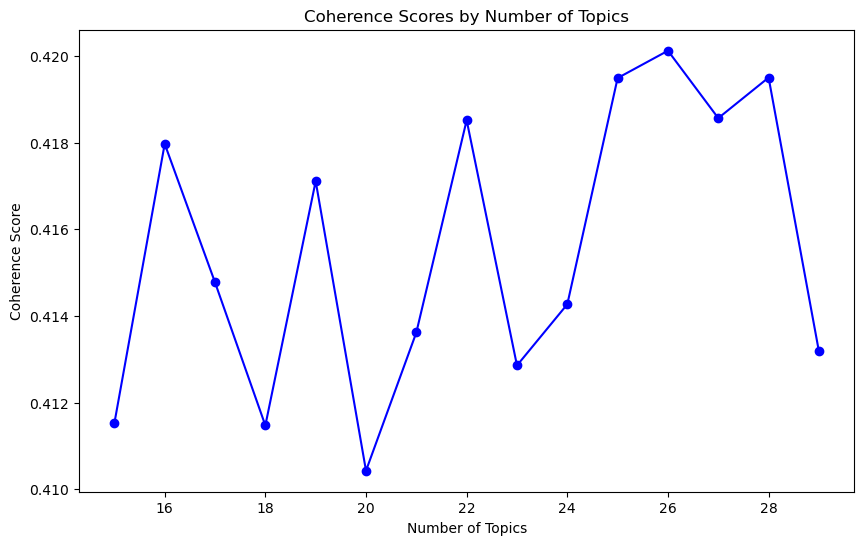

Best Number of Topics: 26 with Coherence Score: 0.4201239178701781


In [9]:
name_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['processed_name'],  CountVectorizer(), range(15, 30,1))

Number of Topics: 1, Coherence Score: 0.7199227576324339
Number of Topics: 2, Coherence Score: 0.7581224639908852
Number of Topics: 3, Coherence Score: 0.7339142062091483
Number of Topics: 4, Coherence Score: 0.7387816936721203
Number of Topics: 5, Coherence Score: 0.7601362295148558
Number of Topics: 6, Coherence Score: 0.7476884894967143
Number of Topics: 7, Coherence Score: 0.763499885942509
Number of Topics: 8, Coherence Score: 0.7439877346234085


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 9, Coherence Score: 0.7335299172425792


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 10, Coherence Score: 0.7234204802778106


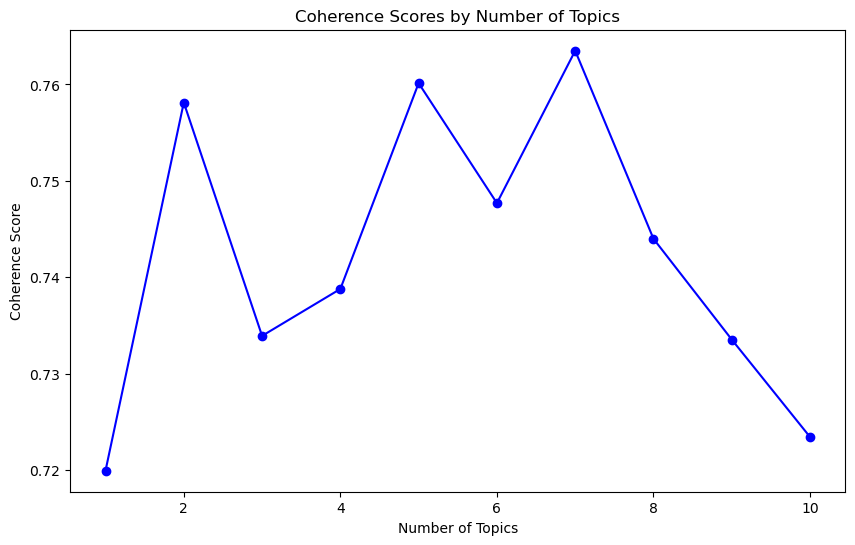

Best Number of Topics: 7 with Coherence Score: 0.763499885942509


In [10]:
name_ingredients_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_name_ingredients'],  CountVectorizer(), range(1, 11, 1))

c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 1, Coherence Score: 0.5212533537739432
Number of Topics: 2, Coherence Score: 0.4439557837315793
Number of Topics: 3, Coherence Score: 0.46192942102924334


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 4, Coherence Score: 0.525067291274623


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 5, Coherence Score: 0.5362538536902862
Number of Topics: 6, Coherence Score: 0.5248898650573186
Number of Topics: 7, Coherence Score: 0.5112016147453257
Number of Topics: 8, Coherence Score: 0.5222941617712255
Number of Topics: 9, Coherence Score: 0.5335981358279595
Number of Topics: 10, Coherence Score: 0.5471448958092325


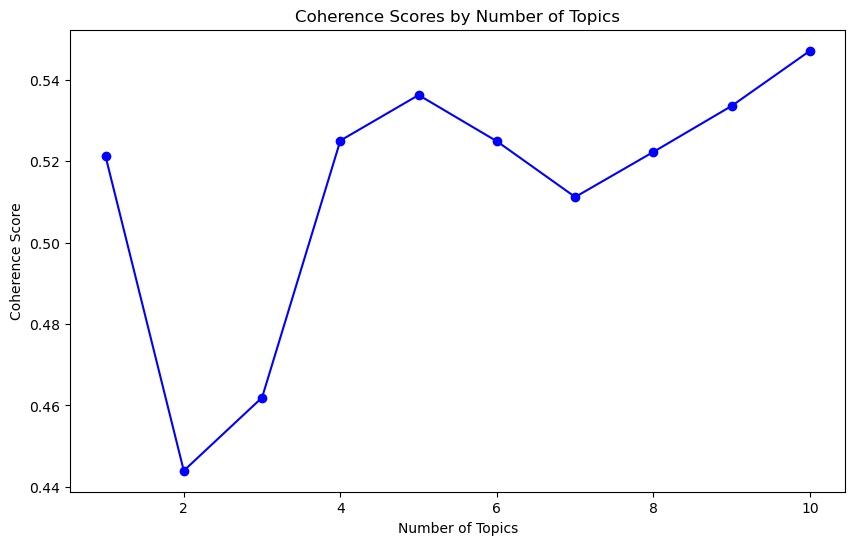

Best Number of Topics: 10 with Coherence Score: 0.5471448958092325


In [11]:
texts_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_texts'],  CountVectorizer(), range(1, 11, 1))

c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 1, Coherence Score: 0.5322565641141608
Number of Topics: 2, Coherence Score: 0.4484536348793794
Number of Topics: 3, Coherence Score: 0.4595034038256274


c:\Users\rogha\anaconda3\envs\Tasty_AI\lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Number of Topics: 4, Coherence Score: 0.5123170433635982
Number of Topics: 5, Coherence Score: 0.5094930912457755
Number of Topics: 6, Coherence Score: 0.5017012670283151
Number of Topics: 7, Coherence Score: 0.5209550814164087
Number of Topics: 8, Coherence Score: 0.5240207326556892
Number of Topics: 9, Coherence Score: 0.5500905739280604
Number of Topics: 10, Coherence Score: 0.5764622139801403
Number of Topics: 11, Coherence Score: 0.5589276569371688
Number of Topics: 12, Coherence Score: 0.5506465412775271
Number of Topics: 13, Coherence Score: 0.5517795825365579
Number of Topics: 14, Coherence Score: 0.5617701791880828


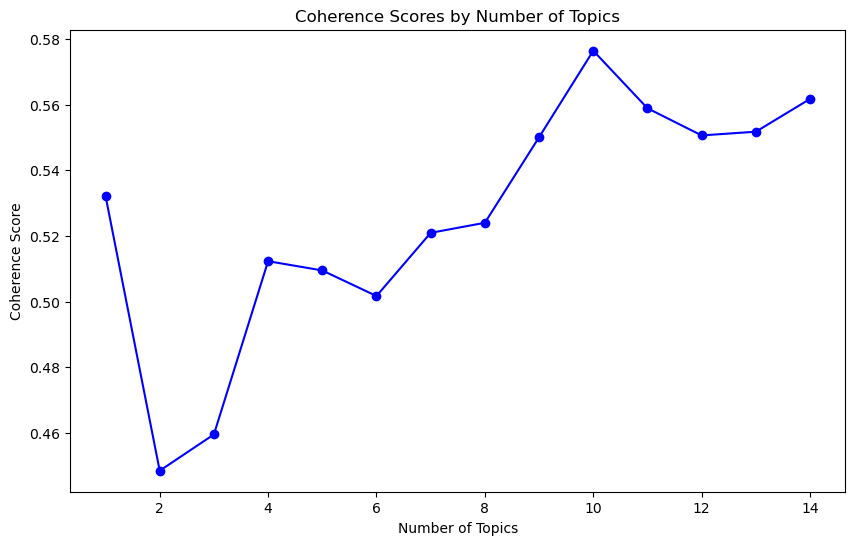

Best Number of Topics: 10 with Coherence Score: 0.5764622139801403


In [12]:
all_coherence_scores_nmf_countvect = compute_coherence_scores_nmf(processed_df['combined_all'],  CountVectorizer(), range(1, 15, 1))

Choose the model with the highest coherence score for more explorations

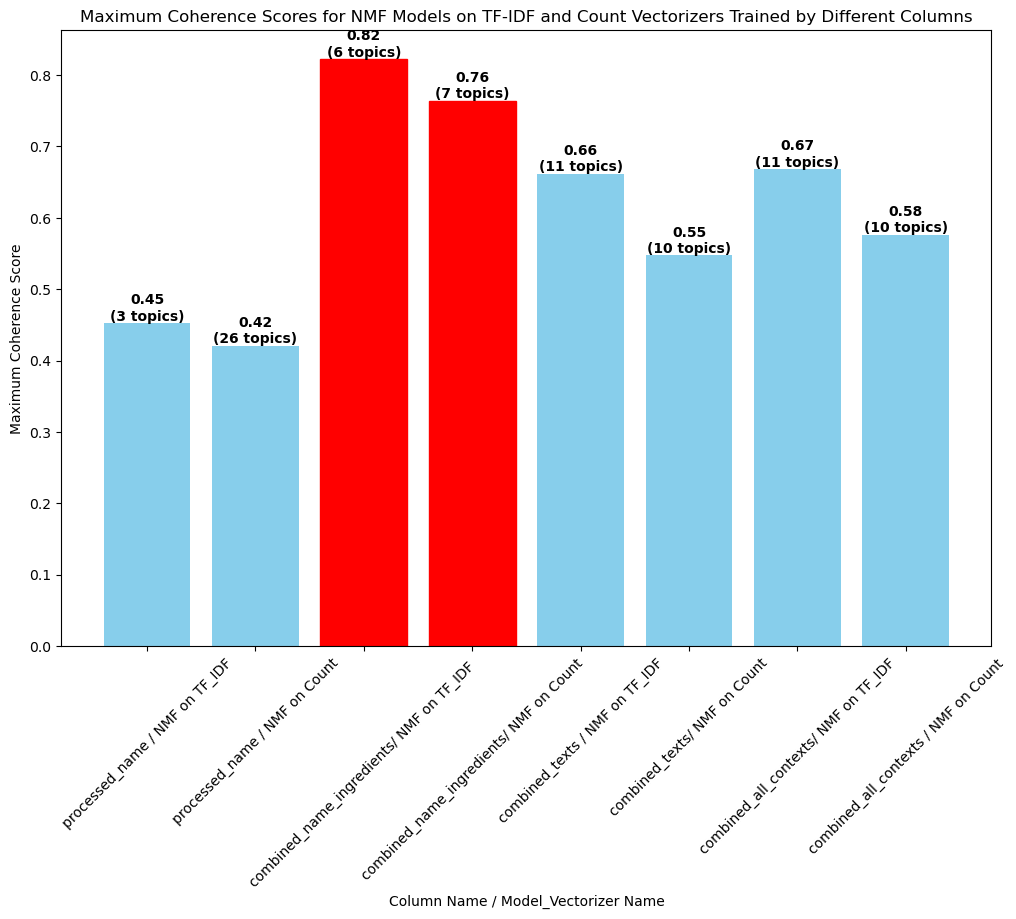

In [13]:
coherence_scores_dict = {"processed_name / NMF on TF_IDF": name_coherence_scores_nmf_tfidf[0],
    "processed_name / NMF on Count": name_coherence_scores_nmf_countvect[0],                 
    "combined_name_ingredients/ NMF on TF_IDF ": name_ingredients_coherence_scores_nmf_tfidf[0],
    "combined_name_ingredients/ NMF on Count": name_ingredients_coherence_scores_nmf_countvect[0],
    "combined_texts / NMF on TF_IDF": texts_coherence_scores_nmf_tfidf[0], 
    "combined_texts/ NMF on Count": texts_coherence_scores_nmf_countvect[0],
    "combined_all_contexts/ NMF on TF_IDF": all_coherence_scores_nmf_tfidf[0],     
     "combined_all_contexts / NMF on Count": all_coherence_scores_nmf_countvect[0]}

# Best topic numbers
best_num_topics = [name_coherence_scores_nmf_tfidf[1], name_coherence_scores_nmf_countvect[1],
                   name_ingredients_coherence_scores_nmf_tfidf[1], name_ingredients_coherence_scores_nmf_countvect[1],
                   texts_coherence_scores_nmf_tfidf[1], texts_coherence_scores_nmf_countvect[1],
                   all_coherence_scores_nmf_tfidf[1], all_coherence_scores_nmf_countvect[1]]

# Extract coherence scores and assign best topics
labels = list(coherence_scores_dict.keys())
max_scores = [max(scores) for scores in coherence_scores_dict.values()]
best_topics_for_each = [best_num_topics[i] for i in range(len(labels))]

# Get indices of the two highest scores
top_two_indices = sorted(range(len(max_scores)), key=lambda i: max_scores[i], reverse=True)[:2]

plt.figure(figsize=(12, 8))
bars = plt.bar(labels, max_scores, color='skyblue')

# Highlight the bars with the two highest coherence scores in red
for idx in top_two_indices:
    bars[idx].set_color('red')

# Annotate each bar with the coherence score and best topic count
for bar, score, topics in zip(bars, max_scores, best_topics_for_each):
    plt.text(bar.get_x() + bar.get_width() / 2, score, f'{score:.2f}\n({topics} topics)', 
             ha='center', va='bottom', fontweight='bold', color='black')

plt.xlabel("Column Name / Model_Vectorizer Name")
plt.ylabel("Maximum Coherence Score")
plt.title("Maximum Coherence Scores for NMF Models on TF-IDF and Count Vectorizers Trained by Different Columns")
plt.xticks(rotation=45)

plt.show()

Train the best NMF model on TF-IDF with the optimal number of topics

In [14]:
best_num_topics = 6
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_df['combined_name_ingredients'])

# Train the NMF model with the optimal number of topics
nmf_model = NMF(n_components=best_num_topics, random_state=42)
nmf_model.fit(tfidf_matrix)
topic_matrix = nmf_model.transform(tfidf_matrix)

# Sum the topic weights across all recipes for each topic
topic_distribution = np.sum(topic_matrix, axis=0)

# Get the feature names (vocabulary) from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Sum TF-IDF scores across all recipes
tfidf_scores = tfidf_matrix.sum(axis=0).A1  

# Create a dictionary of words and their TF-IDF scores
word_tfidf_dict = dict(zip(feature_names, tfidf_scores))

A- Display the top words for each topic in the best NMF model

In [15]:
num_top_words = 20  
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic {topic_idx + 1}: {' '.join(top_words)}")

Topic 1: powder coriander masala dhania chilli jeera cumin turmeric haldi garam red ginger green aloo salt onion potato garlic seeds oil
Topic 2: dal split urad chana bengal moong gram white toor arhar rice asafoetida hing green yellow chilli ghee whole idli dry
Topic 3: pepper bell capsicum olive virgin extra green cheese black sauce garlic onion carrot corn oil salt gajjar bean lemon red
Topic 4: flour sugar milk whole wheat maida ghee purpose water almond badam butter powder elaichi cardamom saffron egg vanilla chocolate strand
Topic 5: cardamom elaichi cinnamon dalchini stick clove laung pod bay tej patta seed leaf black rice peppercorn ginger ghee chicken mutton
Topic 6: seed mustard curry kadugu coconut dry chilli tamarind fresh red oil asafoetida hing sprig methi fenugreek raw sesame seeds salt


B- Plot the topic distribution for the best NMF model

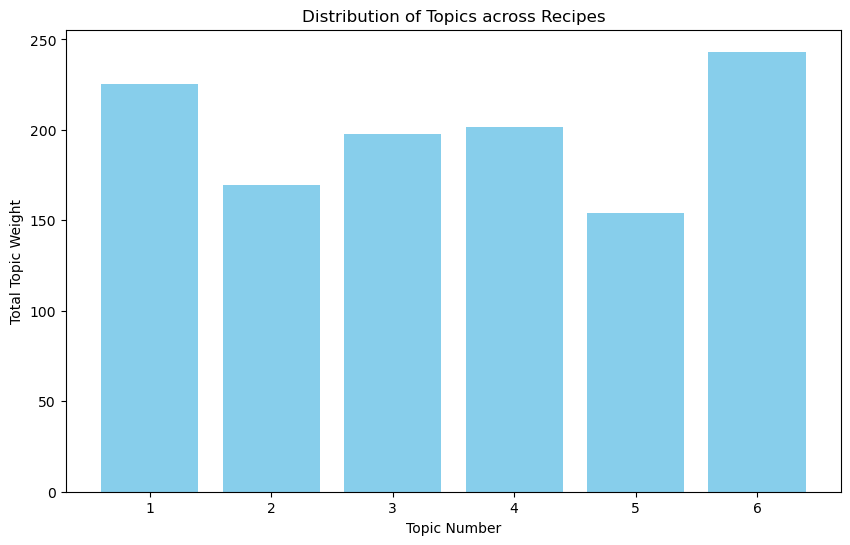

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, best_num_topics + 1), topic_distribution, color='skyblue')
plt.xlabel("Topic Number")
plt.ylabel("Total Topic Weight")
plt.title("Distribution of Topics across Recipes")
plt.xticks(range(1, best_num_topics + 1))  # Label each topic
plt.show()

C- Plot the word cloud for the best NMF model

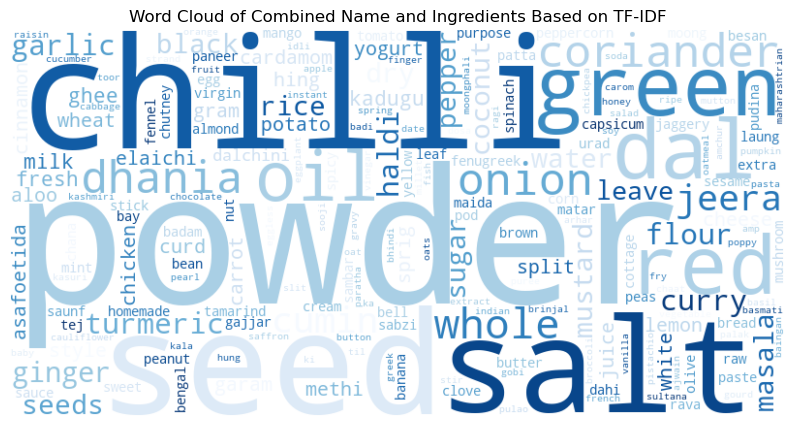

In [25]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues')
wordcloud.generate_from_frequencies(word_tfidf_dict)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Combined Name and Ingredients Based on TF-IDF")
plt.show()

D- Plot 2D t-SNE for the topics of best model with words

In [18]:
topic_matrix.shape

(9496, 6)

In [19]:
topic_matrix.argmax(axis=1)

array([3, 0, 0, ..., 5, 5, 5], dtype=int64)

In [20]:
def plot_tsne_nmf_topics(nmf_model, tfidf_matrix, topic_matrix, feature_names, best_num_topics=6, perplexity=5):
   
    tsne_model = TSNE(n_components=2, perplexity=perplexity, init='pca', random_state=42)
    tsne_embedding = tsne_model.fit_transform(topic_matrix)

    # Create DataFrame for the t-SNE plot
    tsne_df = pd.DataFrame(tsne_embedding, columns=['x', 'y'])
    tsne_df['Topic'] = topic_matrix.argmax(axis=1)
    
    # Extract top words for each topic
    top_words_per_topic = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_word_indices = topic.argsort()  # Top 10 words by topic
        words = [feature_names[i] for i in top_word_indices]
        top_words_per_topic.append(words)
    
    # Assign each word a position in t-SNE space and its associated topic
    words_x, words_y, word_text, word_topics = [], [], [], []
    for topic_num, words in enumerate(top_words_per_topic):
        topic_points = tsne_embedding[tsne_df['Topic'] == topic_num]
        for i, word in enumerate(words):
            words_x.append(topic_points[i % len(topic_points)][0])  # Cycle through topic points
            words_y.append(topic_points[i % len(topic_points)][1])
            word_text.append(word)
            word_topics.append(topic_num + 1)

    # Plot interactive t-SNE with individual words
    fig = go.Figure()

    # Scatter plot for each word in each topic with hover text only
    fig.add_trace(go.Scatter(
        x=words_x,
        y=words_y,
        mode='markers',
        marker=dict(
            size=10, 
            color=word_topics, 
            colorscale='Blues', 
            colorbar=dict(title="Topic", tickvals=[1, 2, 3, 4, 5, 6], ticktext=[f"Topic {i}" for i in range(1, 7)]),
            showscale=True
        ),
        text=word_text,
        hoverinfo='text'
    ))

    # Calculate topic centers and add them to the plot
    topic_centers = np.array([tsne_embedding[tsne_df['Topic'] == i].mean(axis=0) for i in range(best_num_topics)])
    for i, (x, y) in enumerate(topic_centers):
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode='markers+text',
            marker=dict(size=15, symbol='x', color='red'),
            text=[f"Topic {i+1} Center"],
            textposition="top center",
            hoverinfo='text',
            name=f'Topic {i+1} Center'
        ))

    # Update layout to make the plot square and fix legend
    fig.update_layout(
        title="2D t-SNE Plot of Topics with Words in NMF Model on TF-IDF",
        xaxis=dict(visible=False, scaleanchor="y", scaleratio=1),
        yaxis=dict(visible=False),
        width=800,
        height=800,
        showlegend=False,
        hovermode="closest"
    )

    # Add custom legend for topics (1 to 6)
    for i in range(1, best_num_topics + 1):
        fig.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=i, colorscale='Blues', colorbar=None),
            name=f'TopicS {i}'
        ))

    fig.show()

In [21]:
# Plot the 2D t-SNE for NMF topics
plot_tsne_nmf_topics(nmf_model, tfidf_matrix, topic_matrix, feature_names)